# PandaScore Machine Learning/ Computer Vision Assignment

## Introduction
The task you have to complete is to get the cooldown of summoner spells in League of Legends.
If you don't know the game, that's all right, you can find some documentation here:
- https://leagueoflegends.fandom.com/wiki/Summoner_spell
Once a summoner spell has been used, the player will have to wait a certain amount of time (called cooldown)  before the spell can be used again.
This information (the cooldown) is displayed on the HUD of the game and can be really usefull for Pandascore, for our data customers but also to feed our live prediction model.
Indeed, if all players of team A have their 2 summoner spells in cooldown during a team fight, it is very likely that team B is going to win the fight.

## The data

The data consists of images of summoner_spells under cooldown or not. The label is a percentage (100 if there is no cooldown anymore, 10 if 10% of the cooldown time is finished etc.)

Example:

INPUT

![Heal under CD](./dataset/train/inputs/heal_197601_player_2_summ_1_0283_55807.png)

OUTPUT

`57`

The train set and test sets are given so that you can focus on building the model.

In [1]:
import glob, os
import json
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# root folder of data files
root = 'dataset/'
r_dirs = os.listdir(root)
print(r_dirs)

['.DS_Store', 'test_easy', 'train', 'test_hard']


## Load data from files (images and labels)

In [3]:
def load_data(folder):
    # Load data from folders
    imgs = glob.glob(folder + 'inputs/' + '*.png')

    with open(folder+'labels.json') as json_file:
        labels = json.load(json_file)
    return imgs, labels

tr_X, tr_Y = load_data(root+'train/')
print('# train images: ', len(tr_X), 'labels: ', len(tr_Y))
test1_X, test1_y = load_data(root+'test_easy/')
print('# easy_test images: ', len(test1_X), 'labels: ', len(test1_y))
test2_X, test2_y = load_data(root+'test_hard/')
print('# hard_test images: ', len(test2_X), 'labels: ', len(test2_y))

# train images:  100 labels:  100
# easy_test images:  200 labels:  200
# hard_test images:  200 labels:  200


## Plot one example of the data together with label

(20, 20, 3)
hexflash_197636_player_4_summ_0_0376_96915.png
68


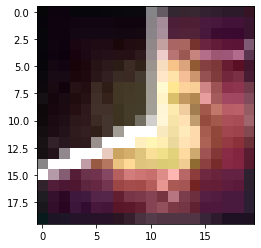

In [4]:
def view_rng_img(imgs, labs, rng = None):
    if len(imgs) != len(labs):
        print('imgs and labels not same length')
        return None
    if rng == None:
        rng = np.random.randint(0,len(imgs))
    im = imgs[rng]
    im_key = os.path.basename(im)
    lab = labs[im_key]
    im = plt.imread(im)
    
    print(im.shape)
    print(im_key, lab, sep='\n')
    plt.imshow(im)
    plt.show()
    return im
    
ret = view_rng_img(tr_X, tr_Y)

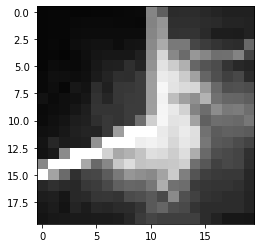

In [5]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
gray = rgb2gray(ret)    
plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

## Plot several examples

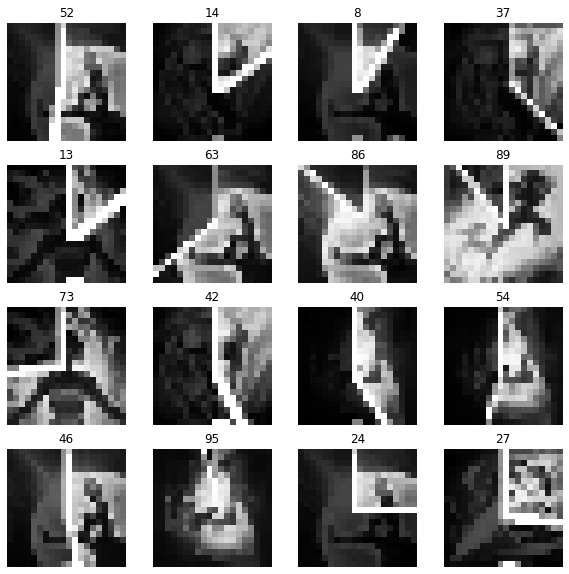

In [9]:
# VIS IMAGES
def plot_several(x,y, rng=False):
    plt.figure(figsize=(10,10))
    columns = 4
    for i, image in enumerate(x):
        if i == columns*columns:
            break
        if rng:
            # random images from set
            image = x[np.random.randint(0,len(x))]
        tit = y[os.path.basename(image)]
        plt.subplot(columns, columns, i + 1, title = tit)
        im = plt.imread(image)
        if 0:
            gray = rgb2gray(im)    
            plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
        else:
            plt.imshow(im)
        plt.axis('off')
plot_several(tr_X, tr_Y)

## Prepare data
No special preprocessing done, since the images are already in small value range -> just loading images as an array and collecting them in a list.

In [16]:
# DATA prep
def data_lists(imgs, labs):
    if len(imgs) != len(labs):
        print('imgs and labels not same length')
        return None
    X_data = []
    y_data = []
    for im in imgs:
        # read the img array
        X_data.append(plt.imread(im))
        # read the label
        y_data.append(labs[os.path.basename(im)])

    return np.array(X_data), np.array(y_data)

X_train, y_train = data_lists(tr_X, tr_Y)
#print(y_train)

# test easy for validation
X_val, y_val = data_lists(test1_X, test1_y)

# test hard for testing
X_test, y_test = data_lists(test2_X, test2_y)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)
if 1:
    y_train = y_train/100
    y_val = y_val/100
    y_test = y_test/100

(100, 20, 20, 3) (100,)
(200, 20, 20, 3) (200,)
(200, 20, 20, 3) (200,)


## Let's have a look at our labels
Here we can see the label distribution among our datasets. We can observe that the train set has some areas like between 10 - 30 and 70-90 with fewer samples.

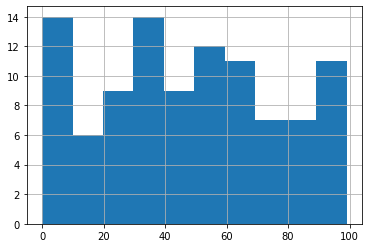

In [99]:
# Training set
plt.hist(y_train*100, density=False, bins=10)
plt.grid()

As noted above the training set has some 'holes' in the dataset with fewer samples.

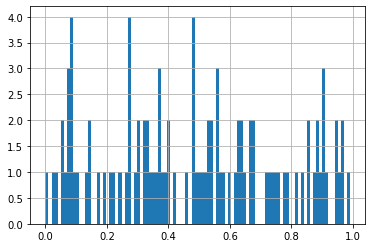

In [18]:
# Training set 100 bins
plt.hist(y_train, density=False, bins=100)
plt.grid()

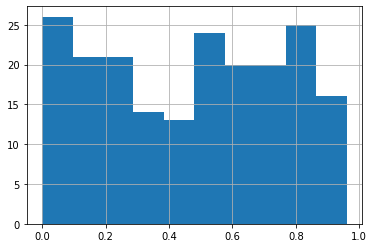

In [19]:
# Test_easy
plt.hist(y_val, density=False, bins=10)
plt.grid()
#plt.savefig('easy_hist_100.png')

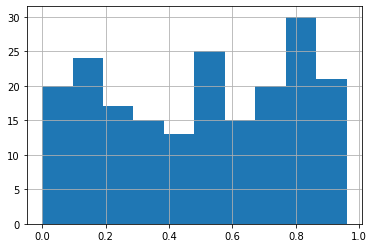

In [20]:
plt.hist(y_test, density=False, bins = 10)
plt.grid()
#plt.savefig('hard_hist_100.png')

## Load keras libraries

In [21]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.layers import BatchNormalization


Using TensorFlow backend.


## Model parameters and definition

In [86]:
LR = 0.001
# LR = 0.00005
#mean-squared-error
loss = 'mse'  
# loss = 'binary_crossentropy'

def net():
    model = Sequential(inp_shape)
    #model.add(BatchNormalization(input_shape=(20, 20, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=inp_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
#     model.add(Dense(1))
    
#     opt = keras.optimizers.SGD(lr=LR, momentum=0.9)
    opt = keras.optimizers.Adam(lr=LR)
    model.compile(optimizer=opt, loss=loss)
    return model

inp_shape = (20, 20, 3)
model = net(inp_shape)
# Print model summary
# model.summary()


## Fit model with 100 epochs
Also use Early Stopping i.e. that as soon as the model does not learn anymore it will kill the learning process

In [87]:
callbacks = [EarlyStopping(monitor='val_loss', patience=15),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
e = 1000
batch = 8
#history = model.fit(X_train, y_train, epochs=e, batch_size=batch, validation_split = 0.1)
history = model.fit(X_train, y_train, shuffle=True, callbacks=callbacks, epochs=e, batch_size=batch, validation_data=(X_val, y_val))

Train on 100 samples, validate on 200 samples
Epoch 1/1000
100/100 [==============================] - 0s 1ms/step - loss: 0.0886 - val_loss: 0.0447
Epoch 2/1000
100/100 [==============================] - 0s 473us/step - loss: 0.0226 - val_loss: 0.0173
Epoch 3/1000
100/100 [==============================] - 0s 409us/step - loss: 0.0140 - val_loss: 0.0220
Epoch 4/1000
100/100 [==============================] - 0s 360us/step - loss: 0.0108 - val_loss: 0.0078
Epoch 5/1000
100/100 [==============================] - 0s 384us/step - loss: 0.0056 - val_loss: 0.0123
Epoch 6/1000
100/100 [==============================] - 0s 353us/step - loss: 0.0057 - val_loss: 0.0066
Epoch 7/1000
100/100 [==============================] - 0s 398us/step - loss: 0.0046 - val_loss: 0.0068
Epoch 8/1000
100/100 [==============================] - 0s 344us/step - loss: 0.0032 - val_loss: 0.0058
Epoch 9/1000
100/100 [==============================] - 0s 385us/step - loss: 0.0026 - val_loss: 0.0050
Epoch 10/1000
100/10

In [88]:
# save model just-in-case
if 0:
    model.save("cdn_model.h5")
else:
    # load best model
    model = load_model('best_model.h5')

## Plotting loss curve

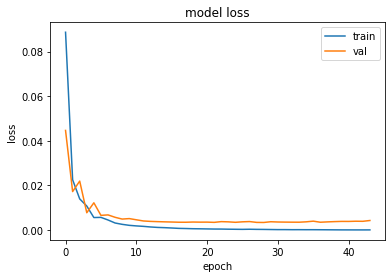

In [89]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Let's see some predictions

In [90]:
# test with random imgs
def pred_img(imgs, labs, idx = None):
    if idx == None:
        idx = np.random.randint(0,len(imgs))
    im = imgs[idx]
    inp_im = plt.imread(im).reshape(1,20,20,3)
    #print(inp_im.shape)
    im_key = os.path.basename(im)
    print('true label = ', labs[im_key])
    print('pred label = ', model.predict(inp_im)*100)

print('train data:')
pred_img(tr_X, tr_Y)
print('easy testing:')
pred_img(test1_X, test1_y)
print('hard testing:')
pred_img(test2_X, test2_y)

train data:
true label =  91
pred label =  [[91.20498]]
easy testing:
true label =  77
pred label =  [[85.83322]]
hard testing:
true label =  40
pred label =  [[44.1315]]


## Predictions against our data

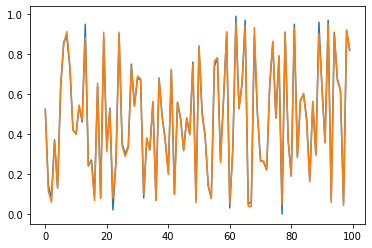

In [91]:
pred = model.predict_proba(X_train)
plt.plot(y_train)
plt.plot(pred)

In [92]:
from utils import calc_metrics, bubbles_plot

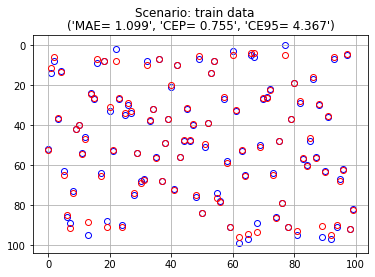

In [93]:
def eval_model(X,y, name = None):
    # get predictions
    pred = model.predict_proba(X)
    # calc MAE CEP CE95 and plot
    bubbles_plot((y*100, pred*100), name)
    
eval_model(X_train, y_train, 'train data')

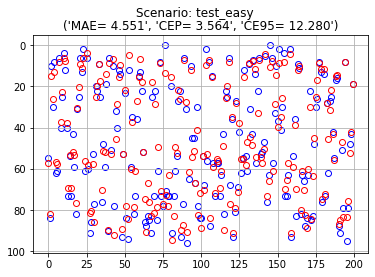

In [94]:
eval_model(X_val, y_val, 'test_easy')

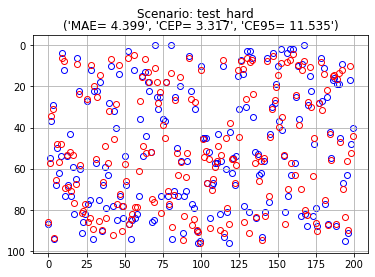

In [95]:
eval_model(X_test, y_test, 'test_hard')

## How well did we train?

In [96]:
def eval_err(x,y, name):
    pred = model.predict_proba(x)
    ER, MAE, CEP, CE95 = calc_metrics((y*100, pred*100))
    print('MAE= %.3f' % MAE, 'CEP= %.3f' % CEP, 'CE95= %.3f' % CE95)
    #print(y[-20:])
    #print(pred[-20:])
    #print(ER[-20:])
    plt.plot(ER)
    plt.grid()
#     plt.savefig(name+'.png')
    std = np.std(ER)
    print('std = ', std)
    return ER, MAE, std

Here we are looking at the calculated error between the true and predicted value

MAE= 1.099 CEP= 0.755 CE95= 4.367
std =  1.2345627048252041


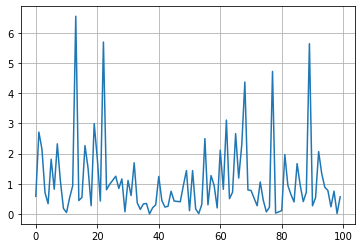

In [97]:
tr_ER, tr_MAE, tr_STD = eval_err(X_train, y_train, 'train_ER')

/Users/arneniitsoo/workStation/virtEnvs/bananasEnv/lib/python3.7/site-packages/keras/engine/sequential.py:248: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


MAE= 4.056 CEP= 3.523 CE95= 10.426
std =  3.053396900796997


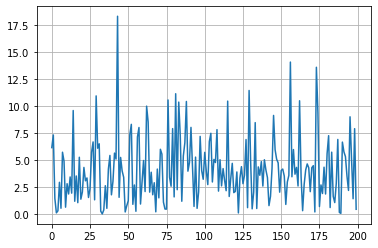

In [23]:
_,_,_ = eval_err(X_val, y_val, 'easy_ER')

/Users/arneniitsoo/workStation/virtEnvs/bananasEnv/lib/python3.7/site-packages/keras/engine/sequential.py:248: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


MAE= 4.451 CEP= 3.485 CE95= 11.985
std =  3.7581794110810587


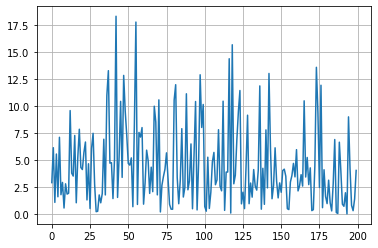

In [24]:
_,_,_ = eval_err(X_test, y_test, 'hard_ER')

## Let's have a closer look where did our model not learn in training phase
* tr_ER
* tr_MAE
* tr_STD

In [25]:
# get the indicies
e = tr_MAE+2*tr_STD
idx = np.where(tr_ER>e)[0]
print('Indicies where we have > {} error'.format(e))
print(idx)
# get the labels
elems = [y_train[i] for i in idx]
print('Labels where we have > {} error'.format(e))
print(elems)

names = [tr_X[i] for i in idx]
#names = [os.path.basename(x).split('_')[0] for x in names]
#names

Indicies where we have > 6.465873306242579 error
[13 24 35 55 56 68]
Labels where we have > 6.465873306242579 error
[95, 90, 56, 74, 78, 89]


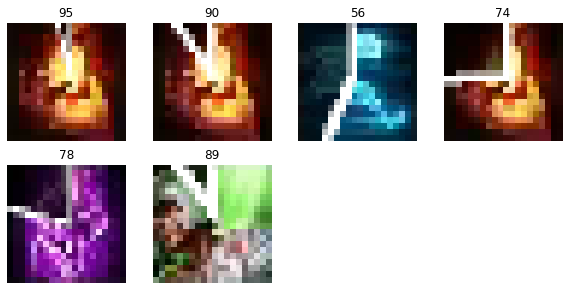

In [26]:

plot_several(names, tr_Y, False)


In [27]:
xd = plt.imread(names[0]).reshape(1,20,20,3)
print('pred label = ', model.predict(xd))
print('true label = ', tr_Y[os.path.basename(names[0])])

pred label =  [[85.13688]]
true label =  95


## Lets look at the test_hard case

MAE= 4.451 CEP= 3.485 CE95= 11.985
std =  3.7581794110810587
Indicies where we have > 11.967492481048073 error
[ 37  42  47  55  81  97 116 118 142 173]
Labels where we have > 11.967492481048073 error
[59, 78, 73, 85, 94, 90, 60, 96, 81, 83]


/Users/arneniitsoo/workStation/virtEnvs/bananasEnv/lib/python3.7/site-packages/keras/engine/sequential.py:248: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


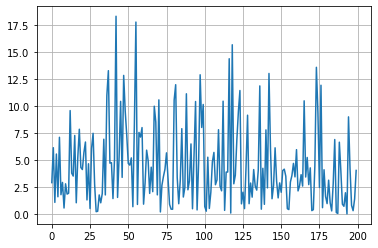

In [28]:
tr_ER,tr_MAE,tr_STD = eval_err(X_test, y_test, 'hard_ER')
# get the indicies
e = tr_MAE+2*tr_STD
idx = np.where(tr_ER>e)[0]
print('Indicies where we have > {} error'.format(e))
print(idx)
# get the labels
elems = [y_test[i] for i in idx]
print('Labels where we have > {} error'.format(e))
print(elems)

names = [test2_X[i] for i in idx]
#names = [os.path.basename(x).split('_')[0] for x in names]
#names

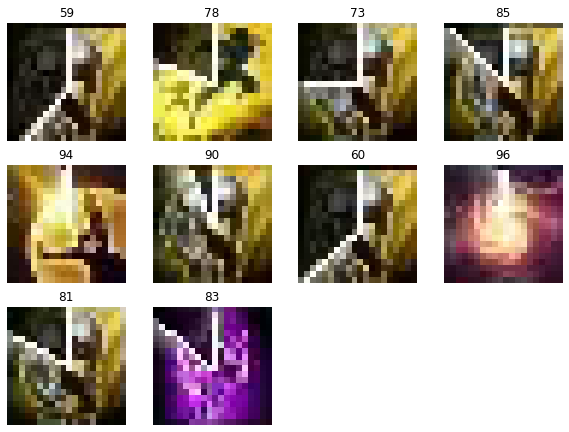

In [29]:
plot_several(names, test2_y, False)

## View prediction values
We can observce that Ghost having a label of 73 in both cases has problems predixcting the correct label.

In [30]:
for i in range(len(names)):
    xd = plt.imread(names[i]).reshape(1,20,20,3)
    print('pred label = ', model.predict(xd))
    print('true label = ', test2_y[os.path.basename(names[i])])

pred label =  [[45.716705]]
true label =  59
pred label =  [[96.323906]]
true label =  78
pred label =  [[60.155636]]
true label =  73
pred label =  [[67.21505]]
true label =  85
pred label =  [[82.015]]
true label =  94
pred label =  [[77.09676]]
true label =  90
pred label =  [[45.61011]]
true label =  60
pred label =  [[80.31581]]
true label =  96
pred label =  [[67.97439]]
true label =  81
pred label =  [[69.40433]]
true label =  83


## Perhaps looking into the count of training samples of barrier could give us hints...

In [31]:
def count_spells(fp):
    asd = [os.path.basename(x).split('_')[0] for x in fp]
    strg = {}
    for item in asd:
        if item in strg.keys():
            strg[item] += 1
        else:
            strg[item] = 1
    return strg

tr_set = count_spells(tr_X)
tr_set

{'barrier': 12,
 'exhaust': 14,
 'cleanse': 8,
 'flash': 9,
 'ignite': 17,
 'smite': 6,
 'ghost': 13,
 'teleport': 6,
 'heal': 7,
 'hexflash': 8}

In [32]:
hard_set = count_spells(test2_X)
hard_set

{'ignite': 17,
 'teleport': 18,
 'exhaust': 18,
 'smite': 20,
 'cleanse': 24,
 'hexflash': 22,
 'flash': 32,
 'heal': 22,
 'ghost': 18,
 'barrier': 9}

MAE= 4.451 CEP= 3.485 CE95= 11.985
std =  3.7581794110810587
Indicies where we have > 15 error
[ 42  55 118]
Labels where we have > 15 error
[78, 85, 96]


/Users/arneniitsoo/workStation/virtEnvs/bananasEnv/lib/python3.7/site-packages/keras/engine/sequential.py:248: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


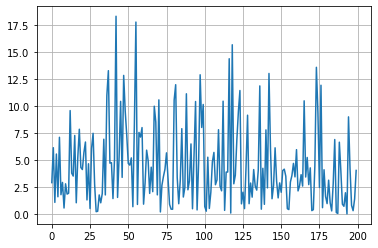

In [33]:
tr_ER,tr_MAE,tr_STD = eval_err(X_test, y_test, 'hard_ER')
# get the indicies
e = 15
idx = np.where(tr_ER>e)[0]
print('Indicies where we have > {} error'.format(e))
print(idx)
# get the labels
elems = [y_test[i] for i in idx]
print('Labels where we have > {} error'.format(e))
#print(elems)
# Sorted
print(sorted(elems))

names = [test2_X[i] for i in idx]


# Conclusion and Summary

The problem at hand is a regression problem. We are trying to predict the % of cooldown progress for the summoner spells in League of Legends. There are total of 10 different summoner spells and then when we consider the range from 0 to 100, a lot of variability is to be expected.

## The training set consisted of 100 examples with the following consistency:
* 'barrier': 12,
* 'exhaust': 14,
* 'cleanse': 8,
* 'flash': 9,
* 'ignite': 17,
* 'smite': 6,
* 'ghost': 13,
* 'teleport': 6,
* 'heal': 7,
* 'hexflash': 8

## With corresponding label distribution:

![training_labels](labels.pdf)

## The goal of the task is to design a neural network which input is a summoner spell image (20,20,3) and output is a value between 0...100.

For my model design I used intuition of combining convolutional layers with pooling layers, followed by dense layer and an output layer. The resulting network is lightweight containing only ~27K parameters.

## Pre-processing data
As we are dealing with regression tasks and not classification. The classical mean reduction method in order to normalize the image seems to be redundant as this might remove important clues about how much is still left -> the counter. Perhaps a inverted edge-detection method could be used in order to remove the color information and only keep the location of the white space indicating the time left on cooldown.


## Training the network

Since the training set had only 100 samples I decided to used the *test_easy* as validation set. Especially, after I noticed that using 0.1 or 0.2 amount of training data for validation would basically leave part of the data available for training unexplored. Additionally, there are data augmentation techniques, which would probably increase model performance. 

I used mean squared error as a commonly used loss function and stochastic gradient descent as optimizer with learning rate of 0.0001 in order to train my model over 100 epochs, batch size of 16 and early stopping with patience value of 15.


## Analysis
From the loss curve, we can observe that the model platoos between 20-40 epochs and does not change significantly. As we notice that the validation error does not jump towards the end of training, we can conclude that the model does not start to overfit (this could be perhaps due to the model size ... low number of parameters).

For model analysis I calculate the RMSE (denoted as MAE), CEP (50% percentile) and CE95. I also plot the true label (in blue) together with predicted label (in red) on a scatter plot in order to visualize the error better.

From the results, we can see that there are some samples where the model has not trained well on and has poorer performance. The birdsview plot (scatter) gives good overview of the errors.

